# Semana 2 - Redes neurais rasas com regressão logística

## Preparação do conjunto de dados

Primeiro, vamos escolher o dataset no qual trabalharemos. Na célula a seguir, pegamos o dataset *etudes*, um subconjunto do dataset *Maestro* que contém apenas algumas peças. Selecionamos as peças de Chopin e Liszt, e nossa tarefa será determinar se a peça pertence a Chopin ou não (classificação binária).

Trabalharemos apenas com duas colunas do conjunto de dados: `composer`, que é o nome do compositor daquela peça, e `midi_list`, que é uma strings com a lista de notas em cada música, em [notação midi](https://en.wikipedia.org/wiki/MIDI). Aqui, representamos as pausas com `-1`, e as notas são separadas por espaço.

In [ ]:
import pandas as pd
etudes = pd.read_csv('https://raw.githubusercontent.com/hype-usp/Hype-Academy/main/Exerc%C3%ADcios%20de%20sala/etudes/etudes_full.csv', index_col = 0)[['composer','midi_list']]
etudes = etudes[(etudes['composer'] == 'Frédéric Chopin') | (etudes['composer'] == 'Franz Liszt')] # filtramos apenas Chopin e Liszt
etudes.index = list(range(0, len(etudes)))
etudes.head()

,composer,midi_list
0,Frédéric Chopin,-1 -1 -1 -1 48 36 48 55 60 -1 64 60 67 72 -1 7...
1,Frédéric Chopin,-1 -1 -1 -1 45 70 71 72 -1 57 73 74 75 76 45 7...
2,Frédéric Chopin,-1 -1 -1 -1 -1 -1 -1 56 80 78 -1 76 -1 75 49 7...
3,Frédéric Chopin,-1 -1 -1 -1 -1 -1 90 58 -1 94 85 90 63 87 90 5...
4,Frédéric Chopin,-1 -1 -1 -1 -1 84 86 84 86 84 -1 86 84 83 84 4...


Abaixo, vemos que nossas classes estão balanceadas, ou seja, temos exatamente o mesmo número de exemplos positivos e negativos. Então, esse é um problema a menos para nos preocuparmos*. 

<sub>*Veremos, mais adiante, que o conjunto de dados original possui muito menos exemplos de peças do Chopin do que de peças que não são do Chopin. Por isso, se ignorarmos esse problema, é bem provável que nosso modelo apenas diga que a peça não é de Chopin, e irá acertar a maioria dos casos, porém não será um modelo útil (ou seja, ele vai acertar, mas não vai saber distinguir o que faz uma peça ser do Chopin ou não).</sub>

In [ ]:
from collections import Counter
Counter(etudes['composer'])

Counter({'Franz Liszt': 14, 'Frédéric Chopin': 14})

Para que consigamos trabalhar com o dataset, queremos fazer o pré-processamento para transformar a string dos valores midi em uma lista de inteiros. No entanto, as músicas possuem tamanhos diferentes, e como vamos utilizar as notas como *features* do modelo, temos que garantir que todos os exemplos de entrada tenham o mesmo número de *features*, ou seja, garantir que todas as músicas tenham o mesmo número de notas.

Uma possível abordagem é pegar o tamanho da menor música e "cortar" todas as outras músicas naquele ponto, "podando" os exemplos de entrada. Isso seria uma opção válida se tivéssemos um conjunto de dados muito grande, e se as músicas fossem mais ou menos do mesmo tamanho. No entanto, vemos que já violamos a primeira condição, pois temos apenas 28 exemplos. A seguir, vemos a distribuição dos tamanhos de cada música, assim como uma descrição resumida da coluna:

count      28.000000
mean     2135.500000
std       851.046132
min       479.000000
25%      1525.750000
50%      1966.000000
75%      2807.000000
max      3761.000000
Name: midi_list, dtype: float64

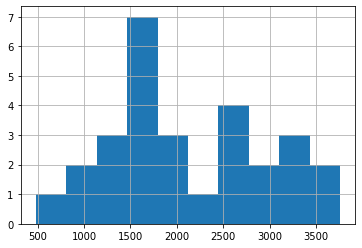

In [ ]:
def split_midi(txt): # precisamos dessa função de split para não incluirmos os espaços na contagem
  return txt.split(' ')[:-1]

h = etudes['midi_list'].apply(split_midi).apply(len).hist()
etudes['midi_list'].apply(split_midi).apply(len).describe()

Vemos que, apesar de possuirmos poucos exemplos, o menor exemplo possui por volta de 1700 notas a menos do que a média. Além disso, olhando para o histograma, vemos que existe uma concentração de músicas com mais notas do que a média. Por isso, perderíamos muita informação caso descartássemos as notas a mais.

Por isso, definiremos que nossa lista de *features* terá o tamanho da maior música, e vamos preencher o restante de todas as outras listas com -1 (que, na nossa notação, significa pausas). Dessa forma, teremos posições "inúteis" nos vetores de entrada, porém não corremos o risco de perder informação.

Na célula abaixo, aplicamos o pré-processamento comentado na lista de inputs(que chamamos de X), e transformamos o nome do compositor numa variável binária (que chamamos de y).

In [ ]:
import numpy as np

def split_midis(txt):
  spl = txt.split(' ')[:-1]
  rsp = []
  for i in range(3761):
    if len(spl) > i:
      rsp.append(int(spl[i]))
    else:
      rsp.append(-1)
  return np.array(rsp)

etudes['X'] = etudes['midi_list'].apply(split_midis)

def is_chopin(txt):
  if 'Chopin' in txt: return 1
  return 0

etudes['y'] = etudes['composer'].apply(is_chopin)

etudes = etudes.drop(columns=['composer', 'midi_list'])
etudes

,X,y
0,"[-1, -1, -1, -1, 48, 36, 48, 55, 60, -1, 64, 6...",1
1,"[-1, -1, -1, -1, 45, 70, 71, 72, -1, 57, 73, 7...",1
2,"[-1, -1, -1, -1, -1, -1, -1, 56, 80, 78, -1, 7...",1
3,"[-1, -1, -1, -1, -1, -1, 90, 58, -1, 94, 85, 9...",1
4,"[-1, -1, -1, -1, -1, 84, 86, 84, 86, 84, -1, 8...",1
5,"[-1, -1, -1, 41, -1, -1, 48, 56, 65, 48, 67, 4...",1
6,"[-1, -1, -1, -1, -1, 63, -1, 44, 68, 80, 60, 5...",1
7,"[-1, -1, -1, -1, -1, 71, 79, 68, -1, 67, -1, 6...",1
8,"[-1, -1, -1, -1, -1, 32, 75, -1, 51, 72, 60, 6...",1
9,"[-1, -1, -1, -1, -1, -1, 71, 40, 63, 64, 55, 6...",1


Para podermos trabalhar com cada número como uma *feature*, vamos separar cada posição do array de X. Assim, cada ítem da lista irá corresponder a uma coluna. Portanto, nosso *dataframe* final terá 3761 colunas.

In [ ]:
X = pd.DataFrame([i for i in etudes['X']])
y = etudes['y']
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3721,3722,3723,3724,3725,3726,3727,3728,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3757,3758,3759,3760
0,-1,-1,-1,-1,48,36,48,55,60,-1,64,60,67,72,-1,76,72,-1,79,84,88,84,91,96,100,96,91,84,-1,88,86,-1,79,72,76,72,67,60,64,60,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,45,70,71,72,-1,57,73,74,75,76,45,77,74,78,79,80,62,74,82,83,84,45,33,86,87,88,89,57,88,87,86,57,84,83,82,81,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,56,80,78,-1,76,-1,75,49,75,72,73,-1,66,74,76,73,75,64,76,78,75,76,66,78,80,76,78,61,80,81,80,85,78,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,90,58,-1,94,85,90,63,87,90,58,90,-1,82,85,78,82,42,78,82,73,78,75,78,58,78,70,73,66,70,37,49,73,68,73,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,84,86,84,86,84,-1,86,84,83,84,41,48,93,-1,-1,91,-1,89,84,81,79,77,72,48,69,47,67,65,60,41,55,53,48,41,53,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Para que não haja problemas com magnitudes de valores, que pode afetar significativamente o aprendizado de uma rede neural, vamos fazer o *scaling* do conjunto de dados utilizando (ou seja, deixar todos os valores de entrada na mesma escala) utilizando o MinMax scaler.

Este scaler irá computar, para cada ítem, a seguinte fórmula:

$X_{MinMax} = \frac{x - x_{min}}{x_{max} - x_{min}}$

E, no final, todos os valores serão números entre 0 e 1, que será o intervalo que utilizaremos para inicializar nossos pesos da rede neural.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X[0][:20])

[0.         0.         0.         0.         0.49       0.43529412
 0.53846154 0.65882353 0.61       0.         0.65       0.67032967
 0.8        0.75257732 0.         0.77       0.8021978  0.
 0.91954023 0.98837209]


Abaixo, dividimos nosso conjunto em treinamento e teste. Utilizaremos o `random_state` para que nosso experimentos sejam replicáveis (mais adiante, iremos comentar um pouco mais sobre a importância disso no aprendizado de redes neurais).

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 100, test_size = 0.2)

Já sabemos que todas as listas de notas possuem 3761 notas, ou seja:

$n_x = 3761$

E como temos 22 exemplos no nosso conjunto de treinamento e 22 no de teste:

$M_{train} = 22, M_{test} = 10$

Portanto, nossa matriz $X$ que contém os dados de treinamento, deverá ter as dimensões $n_x \times M_{train}$, ou seja, $3761 \times 22$.

In [ ]:
X = train_X.T
X.shape

(3761, 22)

Agora, nossos rótulos do conjunto de treinamento, que chamaremos de $y$, deverá ter dimensões $1 \times M_{train}$, ou seja, $1 \times 22$.

In [ ]:
y = np.array([i for i in train_y]).reshape(1,X.shape[1])
y.shape

(1, 22)

## Implementação do modelo

Primeiro, vamos definir a função sigmoide, que será a função de ativação do nosso modelo, por ser a função de ativação de uma regressão logística. Ela é dada por:

$sigmoid(x) = \frac{1}{1 + e^{-x}}$

In [ ]:
import random
import math

def sigmoid(x):
  return 1/(1 + np.exp(-x))

Agora, implementaremos nossa rede neural em si. Primeiramente, definimos o hiperparâmetro `lr`, que é a taxa de aprendizado (*learning rate*), e `epochs`, que é o número de épocas (ou seja, número de vezes que iremos rodar a descida do gradiente).


In [ ]:
lr = 0.1
epochs = 150

Depois, inicializamos nossa lista de pesos como uma matriz linha de numpy com números aleatórios no intervalo entre 0 e 1. A matriz possui apenas uma linha, e o número de colunas é o número de atributos de $X$, ou seja:

$W.shape = 11298 \times 1$

Inicializamos, também, nossa unidade de bias `b` (o *threshold*), um número aleatório entre 0 e 1. Usamos o `rando.seed` para que os nossos experimentos sejam replicáveis: isso é importante em redes neurais porque elas são sensíveis aos pesos iniciais, e como queremos encontrar os melhores hiperparâmetros, queremos poder manter as outras condições constantes.

In [ ]:
np.random.seed(100)
w = np.random.rand(len(X), 1)
random.seed(100)
b = random.random()

Agora, vamos estruturar uma única iteração do algoritmo de descida gradiente. Primeiro, precisamos computar a saída linear dos neurônios de entrada, ou seja:

$Z = W \times X + b$

Que é a operação vetorial (em que $\times$ é o produto matricial, ou `dot product`) que calcula a saída linear para todos os exemplos de entrada, e tem tamanho $1 \times 10$.

Para calcular a previsão do modelo, precisamos, ainda, computar a sigmoide destes valores, ou seja:

$\hat{Y} = sigmoid(Z)$

Que é a operação vetorial que calcula a saída da função sigmoide para todos os exemplos de entrada.

In [ ]:
z = np.dot(w.T, X) + b
y_hat = sigmoid(z)

Nesta etapa, iremos calcular o erro dos nossos neurônios, para que consigamos atualizar os pesos. Por isso, precisaremos aplicar o algoritmo de *backpropagation*, ou seja, devemos derivar a função de perda. Felizmente, já temos essas derivadas prontas!

Vamos relembrar que a nossa função de perda é a seguinte:

$L(\hat{y}, y) = - (y log(\hat{y} + (1 - y)log(1 - \hat{y}))$

E, como queremos calcular essa mesma função para todos os exemplos de treinamento, temos que nossa função de custo é a seguinte:

$J(X) = \frac{1}{M}\sum_{i = 0}^{M - 1}{L(\hat{y}^{(i)}, y^{(i)})}$

Primeiro, precisamos computar a derivada da função de custo em relação à nossa saída linear $Z$, ou seja, $\frac{\partial{L}}{\partial{Z}}$:

$\frac{\partial{J}}{\partial{Z}} = \hat{Y} - Y$

Em seguida, para calcular a derivada da função de custo em relação a $W$:

$\frac{\partial{J}}{\partial{W}} = XZ^{T}$

E por fim, em relação a b:

$\frac{\partial{J}}{\partial{b}} = \frac{\partial{J}}{\partial{Z}} = \hat{Y} - Y$

In [ ]:
dz = (y_hat - y)
db = np.sum(dz)/X.shape[1]
dw = np.dot(X, dz.T)/X.shape[1]

E podemos, por fim, atualizar os pesos com a descida do gradiente:

$W = W - \eta\frac{\partial{J}}{\partial{W}}$  
$b = b - \eta\frac{\partial{J}}{\partial{b}}$

In [ ]:
w -= lr*dw
b -= lr*db

Agora vamos juntar tudo num for para rodarmos por um número específico de épocas, e incluir listas para salvarmos a acurácia, precision e recall em cada época. Colocaremos tudo dentro de duas funções: uma função `epoca`, que irá computar o resultado do modelo em apenas uma época, e a função `treina_modelo`, que irá computar um número específico de épocas. A última irá retornar os pesos aprendidos, para que possamos computar resultados no conjunto de testes posteriormente.

In [ ]:
#@title Implementação do treinamento do modelo
import math

def epoca(X, y, lr, w, b, thr):
  z = np.dot(w.T, X) + b
  y_hat = sigmoid(z)

  dz = (y_hat - y)
  db = np.sum(dz)/X.shape[1]
  dw = np.dot(X, dz.T)/X.shape[1]

  preds = []

  for p in y_hat[0]:
    if p > thr:
      preds.append(1)
    else:
      preds.append(0)

  real = [i for i in y[0]]
  fp = sum([i for i in range(len(preds)) if preds[i] == 1 and real[i] == 0])
  fn = sum([i for i in range(len(preds)) if preds[i] == 0 and real[i] == 1])
  vp = sum([i for i in range(len(preds)) if preds[i] == 1 and real[i] == 1])
  vn = sum([i for i in range(len(preds)) if preds[i] == 0 and real[i] == 0])

  ac = sum([real[i] == preds[i] for i in range(len(real))])/len(real)
  pr = vp/max(vp + fp, 1)
  rc = vp/max(vp + fn, 1)

  w -= lr*dw
  b -= lr*db

  return ac, pr, rc, [vp,fp,fn,vn]

def treina_modelo(X, y, epocas, lr, thr, printar=False):
  np.random.seed(100)
  w = np.random.rand(len(X), 1)*0.01
  random.seed(100)
  b = random.random()*0.01
  acs = []
  prs = []
  rcs = []
  confs = []

  for i in range(epocas):
    ac, pr, rc, conf = epoca(X, y, lr, w, b, thr)
    acs.append(ac)
    prs.append(pr)
    rcs.append(rc)
    confs.append(conf)

  avg_0 = round(sum([a for a,b,c,d in confs])/len(confs),2)
  avg_1 = round(sum([b for a,b,c,d in confs])/len(confs),2)
  avg_2 = round(sum([c for a,b,c,d in confs])/len(confs),2)
  avg_3 = round(sum([d for a,b,c,d in confs])/len(confs),2)
  
  if printar:
    print('AC:', sum(acs)/len(acs))
    print('PR:', sum(prs)/len(prs))
    print('RC:', sum(rcs)/len(rcs))
    # print('Matriz de confusão')
    # print(avg_0, avg_1)
    # print(avg_2, avg_3)
    # print()
  
  return acs, prs, rcs, w, b

E agora, podemos chamar a função para treinar nosso modelo, e plotar a acurácia, precision e recall. Lembre-se: estes valores são para o conjunto de TREINAMENTO, ou seja, não estamos testando ainda se nosso modelo consegue generalizar o que aprendeu. Estamos testando apenas se o modelo é capaz de aprender a resolver o problema proposto com os dados de entrada.

In [ ]:
ac, pr, rc, w, b = treina_modelo(X, y, 70, 0.1, 0.5, True)

AC: 0.9597402597402598
PR: 0.9471954534222883
RC: 0.9606493506493508


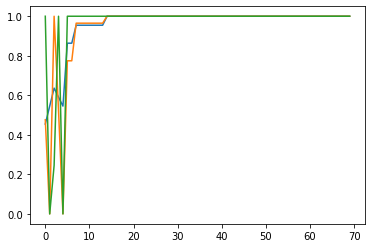

In [ ]:
import seaborn as sns
sns.lineplot(y = ac, x = list(range(len(ac))))
sns.lineplot(y = pr, x = list(range(len(pr))))
sns.lineplot(y = rc, x = list(range(len(rc))))

## Treinamento e teste do modelo

Agora que sabemos que nosso modelo é capaz de aprender, podemos utilizar uma função de *cross validation* para encontrar os melhores hiperparâmetros.

In [ ]:
#@title Implementação da função de *cross validation*

def shuffle(X, y):
  X = pd.DataFrame(X.T)
  X = X.sample(frac=1)
  y = np.array([y[0][i] for i in list(X.index)])
  return X, y

def k_fold(X, y, k):
  folds_X = []
  folds_y = []
  step = math.floor(X.shape[0]/k)
  last = 0
  for i in range(1,k+1):
    if i < k:
      folds_X.append(X[last:i*step])
      folds_y.append(y[last:i*step])
    else:
      folds_X.append(X[last:])
      folds_y.append(y[last:])
    last = i*step

  return folds_X, folds_y

def crossval(X, y, k, epocas, lr, thr):
  X, y = shuffle(X, y)
  
  folds_X, folds_y = k_fold(X, y, k)

  for i in range(k):
    teste_X = folds_X[i]
    teste_y = folds_y[i]
    treino_X = folds_X[0:i] + folds_X[i+1:]
    treino_y = folds_y[0:i] + folds_y[i+1:]

    acs = []
    prs = []
    rcs = []
    ct = 0
    
    for i in range(len(treino_X)):
      ct += 1
      ac, pr, rc, w, b = treina_modelo(treino_X[i].T, treino_y[i].reshape(1, treino_y[i].shape[0]), epocas, lr, thr)
      acs.append(sum(ac)/len(ac))
      prs.append(sum(pr)/len(pr))
      rcs.append(sum(rc)/len(rc))

  return sum(acs)/len(acs), sum(prs)/len(prs), sum(rcs)/len(rcs)

Para utilizar a função, devemos passar como entrada os dados (X e y), o número de *folds* (neste caso, escolhemos 4 por termos muito pouco dado), e os hiperparâmetros do modelo (épocas, taxa de aprendizado, threshold). Recebemos como resposta os valores de acurácia, precisão e recall, nesta ordem.

In [ ]:
crossval(X, y, 4, 50, 0.1, 0.5)

(0.972, 0.6328571428571429, 0.6444444444444445)

E agora que já temos nosso cross validation implementado e funcionando, podemos implementar nosso grid search. Com ele, iremos percorrer um determinado espaço de hiperparâmetros, e utilizar o cross validation para comparar os resultados de cada combinação. No final, escolheremos o conjunto de hiperparâmetros que nos deu a melhor combinação, e os utilizaremos para testar o desempenho do nosso modelo no conjunto de teste. Nesta implementação do grid search, iremos maximizar a medida F1:

$F1 = \frac{2*precision*recall}{precision + recall}$

In [ ]:
#@title Implementação do grid search

def grid_search(hype, X, y, k):
  epocas, lr, thr = hype

  hype_best = (100, 0.01, 0.1)
  metrics_best = (0, 0, 0)
  f1_b = 0

  for e in epocas:
    for l in lr:
      for t in thr:
        m = crossval(X, y, k, e, l, t)
        if m[1] + m[2] != 0:
          f1_m = (2*m[1]*m[2])/(m[1]+m[2])
        else:
          f1_m = 0
        if f1_m >= f1_b:
          metrics_best = m
          f1_b = f1_m
          hype_best = (e, l, t)

  return metrics_best, hype_best 

In [ ]:
epocas = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
lr = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5]
thr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hype = [epocas, lr, thr]

# g = grid_search(hype, X, y, 4)

# print('Hiperparâmetros:', g[1])
# print('Desempenho:', g[0])

Agora que temos um conjunto bom de hiperparâmetros, podemos treinar um modelo com eles e testar seu desempenho no conjunto de testes. Abaixo, vemos que o conjunto de teste possui 6 exemplos e tem o mesmo número de features do conjunto de treinamento.

In [ ]:
X_test = val_X.T
X_test.shape

(3761, 6)

E que nosso conjunto de testes possui 6 exemplos e apenas uma coluna (a classe).

In [ ]:
y_test = np.array(val_y).reshape(1,X_test.shape[1])
y_test.shape

(1, 6)

No código abaixo, vemos a acurácia, precisão, recall e *matriz de confusão* do modelo no conjunto de treinamento:

Desempenho do conjunto de treinamento:
AC: 0.7681818181818182
PR: 0.675875499754239
RC: 0.7545454545454545

Desempenho no conjunto de teste:
AC: 0.5
PR: 0.6666666666666666
RC: 0.5
Matriz de confusão
2 1
2 1



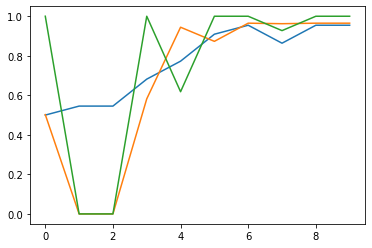

In [ ]:
#@title Teste do modelo no conjunto de teste
import math

epocas = 10
lr = 0.5
thr = 0.9

print('Desempenho do conjunto de treinamento:')
ac, pr, rc, w, b = treina_modelo(X, y, epocas, lr, thr, True)
print()

sns.lineplot(y = ac, x = list(range(len(ac))))
sns.lineplot(y = pr, x = list(range(len(pr))))
sns.lineplot(y = rc, x = list(range(len(rc))))

probs = list(sigmoid(np.dot(w.T, X_test) + b)[0])
preds = []

for p in probs:
  if p > thr:
    preds.append(1)
  else:
    preds.append(0)

real = [i for i in y_test[0]]
fp = sum([1 for i in range(len(preds)) if preds[i] == 1 and real[i] == 0])
fn = sum([1 for i in range(len(preds)) if preds[i] == 0 and real[i] == 1])
vp = sum([1 for i in range(len(preds)) if preds[i] == 1 and real[i] == 1])
vn = sum([1 for i in range(len(preds)) if preds[i] == 0 and real[i] == 0])

ac = sum([real[i] == preds[i] for i in range(len(real))])/len(real)
pr = vp/max(vp + fp, 1)
rc = vp/max(vp + fn, 1)

print('Desempenho no conjunto de teste:')
print('AC:', ac)
print('PR:', pr)
print('RC:', rc)
print('Matriz de confusão')
print(vp, fp)
print(fn, vn)
print()

Vemos que o desempenho no conjunto de teste foi significativamente inferior ao do conjunto de treinamento. Quando isso ocorre, dizemos que ocorreu o *overfitting*, ou seja, o modelo apenas "decorou" os dados ao invés de aprendê-los. Existem diversas causas para o overfitting, e abaixo listamos algumas das mais prováveis:

- Temos muito pouco dado para o tanto de *features* que estamos utilizando, causando o *overfitting* por causa da *maldição da dimensionalidade* (esta é a causa mais provável).
- Falta de regularização no modelo, o que pode fazer com que alguns pesos fiquem muito mais significativos do que outros, ou que nossa matriz de *features* seja extremamente esparsa (o que tem relação com a primeira causa).
- Escolha ruim de hiperparâmetros, por não termos conseguido explorar um espaço maior com o grid search.
- Escolha ruim de *features* para o modelo. Aqui, as *features* podem ser ruins por diversas causas: podem existir *features* que confundem o modelo, *features* desnecessárias ao aprendizado, ou pode ser até que as *features* que escolhemos simplesmente não sejam capazes de resolver o problema proposto. Por exemplo: se nós queremos determinar a altura de uma pessoa, podemos utilizar sua idade, seu gênero, etc., mas se utilizarmos a cor dos olhos e do cabelo, não chegaremos a lugar nenhum, pois essas *features* são inúteis para a solução do problema (eu diria que esta causa é a segunda mais provável).

## Dataset MAESTRO

O primeiro conjunto de dados que utilizamos, o *etudes*, é um subconjunto do [dataset MAESTRO](https://www.kaggle.com/jackvial/themaestrodatasetv2), que contém mais de 1200 exemplos. Nesta parte do notebook, vamos fazer o pré-processamento que havíamos feito para o conjunto de dados *etudes* no restante do conjunto MAESTRO. A maioria das células está comentada para que não sejam executadas automaticamente ao usarmos o botão "Executar tudo".

Primeiramente, vamos nos certificar de que a biblioteca do Kaggle está atualizada. Para isso, na célula abaixo, vamos forçar a reinstalação.

In [ ]:
# !pip install --upgrade --force-reinstall --no-deps kaggle

Para utilizarmos a API do Kaggle, precisamos do arquivo `kaggle.json`, que é criado para cada usuário individual. Primeiro, vamos fazer o upload do arquivo no Colab, depois criar a pasta `~/.kaggle`, e mover o arquivo para essa pasta. As células a seguir fazem esse processo.

In [ ]:
import os
from google.colab import files
import shutil

upload_folder = 'inputs'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)

os.mkdir(upload_folder)

In [ ]:
!mkdir ~/.kaggle

In [ ]:
# uploaded = files.upload()

In [ ]:
# !cp kaggle.json ~/.kaggle

In [ ]:
# !chmod 600 /root/.kaggle/kaggle.json

Agora, importamos o dataset pela API do Kaggle. Ela faz o download de um arquivo `.zip`, por isso devemos descompactá-la.

In [ ]:
# from kaggle.api.kaggle_api_extended import KaggleApi
# api = KaggleApi()
# api.authenticate()
# api.dataset_download_files("kritanjalijain/maestropianomidi")

In [ ]:
# !unzip maestropianomidi.zip

Agora, podemos ler o `.csv` com os metadados dos arquivos. Vamos utilizar principalmente a coluna de compositor e a do nome do arquivo `.mid`.

In [ ]:
# etudes = pd.read_csv('maestro-v3.0.0/maestro-v3.0.0.csv')
# etudes

Para otimizar um pouco o processamento, podemos ver a distribuição das durações das músicas.

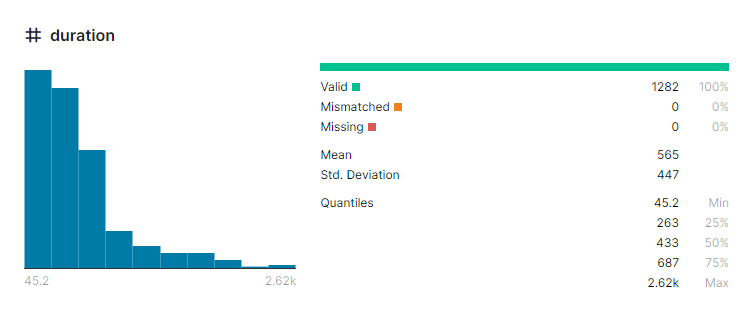

Ao que parece, as peças estão concentradas nos valores abaixo da média. Ou seja: mais de 50% das músicas possuem até 500 segundos, por volta de 8 minutos. Sendo assim, vamos pegar apenas essas músicas com até 500 segundos.

Numa tentativa de otimizar ainda mais este pré-processamento, criaremos uma função que cria a string de midis da música. Depois, criamos uma função vetorizada desta função utilizando o `vectorize` de numpy. Dessa forma, o numpy irá fazer este processamento para todas as notas ao mesmo tempo e otimizar a execução da função.

In [ ]:
import numpy as np
from music21 import *

def case(n):
  if n.isRest: return -1
  elif n.isChord: return n.root().midi
  else: return n.pitch.midi

case_v = np.vectorize(case)

Na célula abaixo, percorremos todos os arquivos, criamos a string de midis e inserimos ela num dataframe. 

OBS.: Esta célula demora por volta de 3 horas para rodar. É... mesmo com as otimizações, ainda é um trabalho bem pesado.

In [ ]:
# import os

# etudes_data = pd.DataFrame(columns=['composer', 'midi_list'])
# files = list(etudes['midi_filename'])

# for path in files:
#   if int(list(etudes[etudes['midi_filename'] == path]['duration'])[0]) > 500: continue
#   print(path, end=' .')
#   song = converter.parse('maestro-v3.0.0/'+path)
#   print('', end='.')
#   composer = list(etudes[etudes['midi_filename'] == path]['canonical_composer'])[0]

#   m = np.array(song.flat.notesAndRests, dtype=object)
#   del song
#   midi = ' '.join([str(i) for i in case_v(m)])
#   del m
#   print('', end='.')

#   line = pd.DataFrame([composer, midi]).transpose()
#   del midi
#   line.columns = ['composer', 'midi_list']
#   print('.', end = '')
#   line.columns = etudes_data.columns
#   line.index = [etudes_data.shape[0]]
#   etudes_data = etudes_data.append(line)
#   print(' done.')

Por fim, salvamos o arquivo como `.csv`!

In [ ]:
#etudes_data

In [ ]:
# etudes_data.to_csv('etudes_data.csv')

## Treinando o modelo com mais dados

Agora que temos o conjunto completo de dados pré-processados, foi necessário apenas hospedá-lo no github e puxá-lo pelo pandas:

In [ ]:
etudes_data = pd.read_csv('https://raw.githubusercontent.com/laiscarraro/Lalasinha-Academy/main/etudes_data.csv', index_col=0)
etudes_data

,composer,midi_list
0,Alban Berg,-1 -1 -1 -1 -1 -1 -1 67 72 -1 78 61 71 67 -1 -...
1,Alexander Scriabin,-1 -1 -1 -1 -1 52 80 -1 81 68 49 83 55 84 52 6...
2,Alexander Scriabin,-1 -1 -1 -1 -1 -1 73 -1 64 74 73 71 73 62 -1 7...
3,Alexander Scriabin,-1 -1 -1 -1 -1 69 64 58 76 78 81 84 -1 72 66 7...
4,Alexander Scriabin,-1 -1 -1 -1 -1 80 65 73 57 -1 -1 -1 58 -1 61 -...
...,...,...
720,Wolfgang Amadeus Mozart,-1 -1 -1 -1 66 -1 50 -1 79 78 76 78 81 64 79 7...
721,Wolfgang Amadeus Mozart,-1 -1 -1 -1 60 -1 65 69 53 41 72 -1 69 48 -1 6...
722,Wolfgang Amadeus Mozart,-1 -1 -1 -1 -1 60 -1 65 53 69 45 72 41 69 -1 2...
723,Wolfgang Amadeus Mozart,-1 -1 -1 -1 -1 73 56 72 -1 73 72 -1 -1 73 72 7...


Agora, temos 725 exemplos que podemos dividir entre treinamento e teste, o que vai dar bem mais informações ao nosso modelo para aprender a diferenciar os compositores. Vamos ver a distribuição do número de notas para encontrar a música com mais notas, assim como fizemos anteriormente.

In [ ]:
def split_midis(txt):
  return [int(i) for i in txt.split(' ')]

etudes_data['X'] = etudes_data['midi_list'].apply(split_midis)

count     725.000000
mean     2237.845517
std       936.977028
min       144.000000
25%      1565.000000
50%      2103.000000
75%      2784.000000
max      5493.000000
Name: num_notes, dtype: float64

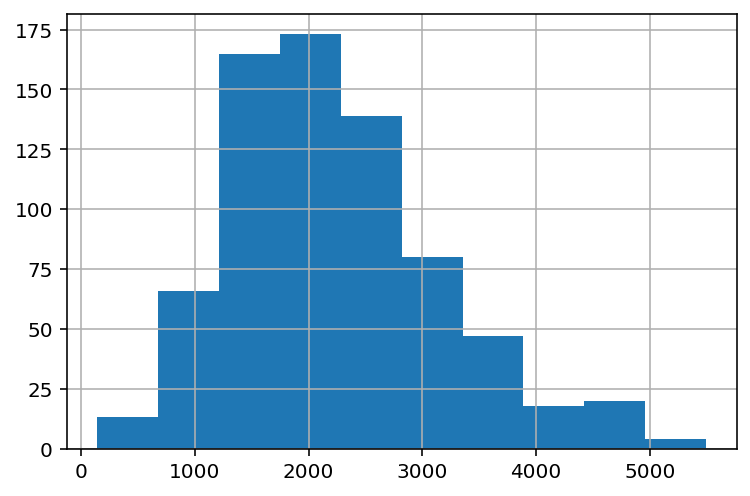

In [ ]:
etudes_data['num_notes'] = etudes_data['X'].apply(len)
h = etudes_data['num_notes'].hist()
etudes_data['num_notes'].describe()

Novamente, vemos que a menor música possui muito menos notas do que a média (por volta de 2100 a menos). Sendo assim, faremos o mesmo pré-processamento que fizemos antes: os inputs terão todos tamanho 5493, e as músicas que contêm menos notas do que isso serão preenchidas com -1.

In [ ]:
import numpy as np

etudes_data = etudes_data.drop(columns=['X'])

def split_midis(txt):
  spl = txt.split(' ')[:-1]
  rsp = []
  for i in range(5493):
    if len(spl) > i:
      rsp.append(int(spl[i]))
    else:
      rsp.append(-1)
  return np.array(rsp)

etudes_data['X'] = etudes_data['midi_list'].apply(split_midis)

def is_chopin(txt):
  if 'Chopin' in txt: return 1
  return 0

etudes_data['y'] = etudes_data['composer'].apply(is_chopin)

etudes_data = etudes_data.drop(columns=['composer', 'midi_list', 'num_notes'])
etudes_data

,X,y
0,"[-1, -1, -1, -1, -1, -1, -1, 67, 72, -1, 78, 6...",0
1,"[-1, -1, -1, -1, -1, 52, 80, -1, 81, 68, 49, 8...",0
2,"[-1, -1, -1, -1, -1, -1, 73, -1, 64, 74, 73, 7...",0
3,"[-1, -1, -1, -1, -1, 69, 64, 58, 76, 78, 81, 8...",0
4,"[-1, -1, -1, -1, -1, 80, 65, 73, 57, -1, -1, -...",0
...,...,...
720,"[-1, -1, -1, -1, 66, -1, 50, -1, 79, 78, 76, 7...",0
721,"[-1, -1, -1, -1, 60, -1, 65, 69, 53, 41, 72, -...",0
722,"[-1, -1, -1, -1, -1, 60, -1, 65, 53, 69, 45, 7...",0
723,"[-1, -1, -1, -1, -1, 73, 56, 72, -1, 73, 72, -...",0


E novamente faremos aquele mesmo pré-processamento: faremos o *scaling* dos dados e dividiremos entre treinamento e teste.

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array([i.T for i in etudes_data['X']])
y = np.array([i for i in etudes_data['y']]).reshape(X.shape[0], 1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

Desta vez, no entanto, temos um problema a mais que precisaremos tratar: o desbalanceamento de classes. Vamos ver a distribuição da nossa classe y:

In [ ]:
from collections import Counter
Counter(etudes_data['y'])

Counter({0: 610, 1: 115})

Como vemos, temos muito mais exemplos de peças que não são do Chopin (0) do que peças que são do Chopin (1). Dessa forma, devemos tratar esse problema já que, caso contrário, o modelo pode simplesmente dizer que nenhuma peça é de Chopin e acertar a maior parte. Uma abordagem possível é utilizar a técnica de *Over sampling*, em que realizamos uma amostragem aleatória com repetição do conjunto da classe minoritária (1) até que o número de exemplos se iguale ao da classe majoritária (0).

In [ ]:
from imblearn.over_sampling import RandomOverSampler

r = RandomOverSampler()
train_X, train_y = r.fit_resample(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

E vemos que agora não temos mais o problema de balanceamento:

In [ ]:
Counter(train_y)

Counter({0: 491, 1: 491})

Agora que temos mais dados, podemos ver que o número de exemplos no conjunto de treinamento é bem maior:

In [ ]:
X = train_X.T
y = train_y.reshape(1,X.shape[1])
X.shape

(5493, 982)

Como já temos as funções de treinamento de modelo todas prontas, podemos simplesmente aplicar o Grid Search no nosso modelo atual para procurar os melhores hiperparâmetros para o novo conjunto de dados.

In [ ]:
epocas = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
lr = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5]
thr = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
hype = [epocas, lr, thr]

# g = grid_search(hype, X, y, 4)

# print('Hiperparâmetros:', g[1])
# print('Desempenho:', g[0])

Hiperparâmetros: (100, 0.01, 0.4)
Desempenho: (0.6757278911564626, 0.6296002467225968, 0.8306576996789872)


E agora que temos os hiperparâmetros certos, podemos apenas usá-los para criar um modelo e testá-lo em nosso conjunto de teste.

Desempenho do conjunto de treinamento:
AC: 0.6610794297352344
PR: 0.7928016594504187
RC: 0.8353654433573858

Desempenho no conjunto de teste:
AC: 0.503448275862069
PR: 0.23255813953488372
RC: 0.7692307692307693
Matriz de confusão
20 66
6 53



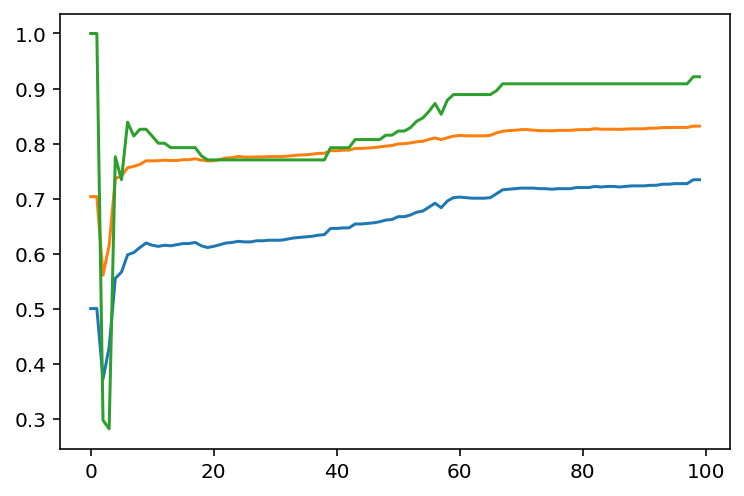

In [ ]:
#@title Teste do modelo no conjunto de teste
import math

epocas = 100
lr = 0.01
thr = 0.4

print('Desempenho do conjunto de treinamento:')
ac, pr, rc, w, b = treina_modelo(X, y, epocas, lr, thr, True)
print()

sns.lineplot(y = ac, x = list(range(len(ac))))
sns.lineplot(y = pr, x = list(range(len(pr))))
sns.lineplot(y = rc, x = list(range(len(rc))))

X_test = val_X.T
y_test = val_y.reshape(1,X_test.shape[1])

probs = list(sigmoid(np.dot(w.T, X_test) + b)[0])
preds = []

for p in probs:
  if p > thr:
    preds.append(1)
  else:
    preds.append(0)

real = [i for i in y_test[0]]
fp = sum([1 for i in range(len(preds)) if preds[i] == 1 and real[i] == 0])
fn = sum([1 for i in range(len(preds)) if preds[i] == 0 and real[i] == 1])
vp = sum([1 for i in range(len(preds)) if preds[i] == 1 and real[i] == 1])
vn = sum([1 for i in range(len(preds)) if preds[i] == 0 and real[i] == 0])

ac = sum([real[i] == preds[i] for i in range(len(real))])/len(real)
pr = vp/max(vp + fp, 1)
rc = vp/max(vp + fn, 1)

print('Desempenho no conjunto de teste:')
print('AC:', ac)
print('PR:', pr)
print('RC:', rc)
print('Matriz de confusão')
print(vp, fp)
print(fn, vn)
print()

Apesar de nosso recall ser um pouco mais alto neste modelo do que no outro, ainda há sinais de *overfitting*, pois a precisão foi significativamente pior no conjunto de teste do que no de treinamento. Apesar de temos mais dados desta vez, é ainda muito provável que nosso modelo esteja esparso demais e sofrendo com a maldição da dimensionalidade, pois ainda temos um número muito maior de *features* do que de exemplos. Na próxima seção, tentaremos 3 abordagens diferentes para conter a maldição da dimensionalidade no nosso conjunto de dados.

## Treinando de uma forma um pouco mais inteligente

In [ ]:
def interval_count(l):
  rsp = []
  for i in range(1,len(l)):
    if l[i-1] == -1 or l[i] == -1: rsp.append(0)
    else: rsp.append(abs(l[i-1] - l[i]))
  return np.array(rsp)

etudes_data['X'] = etudes_data['X'].apply(interval_count)

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X = np.array([i.T for i in etudes_data['X']])
y = np.array([i for i in etudes_data['y']]).reshape(X.shape[0], 1)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

r = RandomOverSampler()
train_X, train_y = r.fit_resample(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
Counter(train_y)

Counter({0: 491, 1: 491})

In [ ]:
X = train_X.T
X.shape

(5492, 982)

In [ ]:
y = train_y.reshape(1,X.shape[1])
y.shape

(1, 982)

In [ ]:
epocas = [100, 50, 20]
lr = [0.01, 0.05, 0.1, 0.3, 0.5]
thr = [0.1, 0.3, 0.5, 0.7, 0.9]
hype = [epocas, lr, thr]

g = grid_search(hype, X, y, 4)

print('Hiperparâmetros:', g[1])
print('Desempenho:', g[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Hiperparâmetros: (100, 0.3, 0.9)
Desempenho: (0.8804897959183674, 0.8670049422553195, 0.887536206055775)


Desempenho do conjunto de treinamento:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


AC: 0.7189378415300546
PR: 0.8143748805180928
RC: 0.7513758606590402

Desempenho no conjunto de teste:
AC: 0.7862068965517242
PR: 0.21428571428571427
RC: 0.13043478260869565
Matriz de confusão
3 11
20 111



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


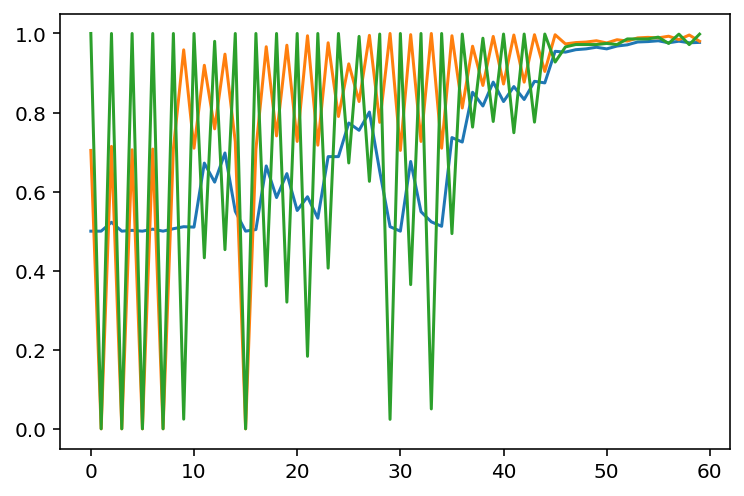

In [ ]:
#@title Teste do modelo no conjunto de teste
import math

epocas = 60
lr = 0.5
thr = 0.9

print('Desempenho do conjunto de treinamento:')
ac, pr, rc, w, b = treina_modelo(X, y, epocas, lr, thr, True)
print()

sns.lineplot(y = ac, x = list(range(len(ac))))
sns.lineplot(y = pr, x = list(range(len(pr))))
sns.lineplot(y = rc, x = list(range(len(rc))))

X_test = val_X.T
y_test = val_y.reshape(1,X_test.shape[1])

probs = list(sigmoid(np.dot(w.T, X_test) + b)[0])
preds = []

for p in probs:
  if p > thr:
    preds.append(1)
  else:
    preds.append(0)

real = [i for i in y_test[0]]
fp = sum([1 for i in range(len(preds)) if preds[i] == 1 and real[i] == 0])
fn = sum([1 for i in range(len(preds)) if preds[i] == 0 and real[i] == 1])
vp = sum([1 for i in range(len(preds)) if preds[i] == 1 and real[i] == 1])
vn = sum([1 for i in range(len(preds)) if preds[i] == 0 and real[i] == 0])

ac = sum([real[i] == preds[i] for i in range(len(real))])/len(real)
pr = vp/max(vp + fp, 1)
rc = vp/max(vp + fn, 1)

print('Desempenho no conjunto de teste:')
print('AC:', ac)
print('PR:', pr)
print('RC:', rc)
print('Matriz de confusão')
print(vp, fp)
print(fn, vn)
print()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe1f802d50>]],
      dtype=object)

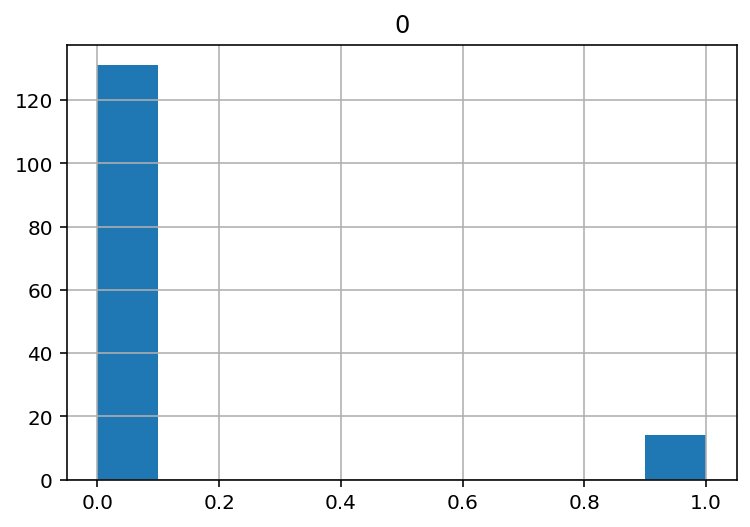

In [ ]:
pd.DataFrame(probs).hist()

## Testando para ver se o problema não é o meu modelo

In [ ]:
import pandas as pd
import numpy as np

etudes_data = pd.read_csv('https://raw.githubusercontent.com/laiscarraro/Lalasinha-Academy/main/etudes_data.csv', index_col=0)

def split_midis(txt):
  spl = txt.split(' ')[:-1]
  rsp = []
  for i in range(5493):
    if len(spl) > i:
      rsp.append(int(spl[i]))
    else:
      rsp.append(-1)
  return np.array(rsp)

etudes_data['X'] = etudes_data['midi_list'].apply(split_midis)

def interval_count(l):
  rsp = []
  for i in range(1,len(l)):
    if l[i-1] == -1 or l[i] == -1: rsp.append(0)
    else: rsp.append(abs(l[i-1] - l[i]))
  return ' '.join([str(i) for i in rsp])

etudes_data['X'] = etudes_data['X'].apply(interval_count)

def is_chopin(txt):
  if 'Chopin' in txt: return 1
  return 0

etudes_data['y'] = etudes_data['composer'].apply(is_chopin)

etudes_data = etudes_data.drop(columns=['composer', 'midi_list'])
etudes_data.head()

,X,y
0,0 0 0 0 0 0 0 5 0 0 17 10 4 0 0 0 0 0 0 0 19 1...,0
1,0 0 0 0 0 28 0 0 13 19 34 28 29 32 10 10 14 13...,0
2,0 0 0 0 0 0 0 0 10 1 2 2 11 0 0 0 0 0 0 5 8 1 ...,0
3,0 0 0 0 0 5 6 18 2 3 3 0 0 6 7 0 0 0 0 3 3 12 ...,0
4,0 0 0 0 0 15 8 16 0 0 0 0 0 0 0 0 20 12 17 9 1...,0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

c = CountVectorizer(ngram_range=(2,2))
X = c.fit_transform(etudes_data['X']).todense()
y = np.array(etudes_data['y'])

print(X.shape)
print(y.shape)

(725, 3233)
(725,)


In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

from imblearn.over_sampling import RandomOverSampler
r = RandomOverSampler()
train_X, train_y = r.fit_resample(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

feature_columns = []
cols = [tf.feature_column.numeric_column(str(i)) for i in range(train_X.shape[1])]

for c in cols:
  feature_columns.append(c)

feature_layer = layers.DenseFeatures(feature_columns)

train_X = pd.DataFrame(train_X)
train_X.columns = [str(c) for c in train_X.columns]

feature_layer(dict(train_X))

<tf.Tensor: shape=(980, 3233), dtype=float32, numpy=
array([[0.03125   , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21875   , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.046875  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0625    , 0.21428572, 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.09375   , 0.21428572, 0.33333334, ..., 0.        , 0.        ,
        0.        ],
       [0.125     , 0.        , 0.08333334, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [ ]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  model = tf.keras.models.Sequential()
  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label,
                batch_size=None, shuffle=True):
  
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(label)
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist  

In [ ]:
import matplotlib.pyplot as plt

def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
4/4 [==============================] - 62s 148ms/step - loss: 2.6767 - accuracy: 0.5847 - precision: 0.5849 - recall: 0.5837
Epoch 2/50
4/4 [==============================] - 1s 153ms/step - loss: 0.3457 - accuracy: 0.9112 - precision: 0.9468 - recall: 0.8714
Epoch 3/50
4/4 [==============================] - 1s 155ms/step - loss: 0.0837 - accuracy: 0.9806 - precision: 0.9856 - recall: 0.9755
Epoch 4/50
4/4 [==============================] - 1s 154ms/step - loss: 0.0460 - accuracy: 0.9888 - precision: 0.9918 - recall: 0.9857
Epoch 5/50
4/4 [==============================] - 1s 152ms/step - loss: 0.0318 - accuracy: 0.9949 - precision: 0.9959 - recall: 0.9939
Epoch 6/50
4/4 [==============================] - 1s 150ms/step - loss: 0.0248 - accuracy: 0.9980 - precision: 0.9959 - recall: 1.0000
Epoch 7/50
4/4 [==============================] - 1s 161ms/step - loss: 0.0199 

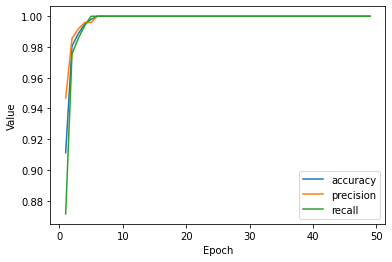

In [ ]:
learning_rate = 0.1
epochs = 50
batch_size = 300
label = train_y
classification_threshold = 0.45

# Establish the metrics the model will measure.
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 )
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_X, epochs, 
                           label, batch_size)

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
val_X = pd.DataFrame(val_X)
val_X.columns = [str(c) for c in val_X.columns]

features = {name:np.array(value) for name, value in val_X.items()}
label = val_y

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
1/1 [==============================] - 42s 42s/step - loss: 1.0861 - accuracy: 0.9034 - precision: 0.9231 - recall: 0.4800


[1.0861420631408691,
 0.9034482836723328,
 0.9230769276618958,
 0.47999998927116394]

In [ ]:
labels = list(val_y)
raw_predictions = list(my_model.predict(features))

Consider rewriting this model with the Functional API.


In [ ]:
predictions = [p[0] for p in raw_predictions]
tf.math.confusion_matrix(labels, predictions)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[120,   0],
       [ 24,   1]], dtype=int32)>

## Testando com o TensorFlow de novo só que agora com as features certas

In [ ]:
etudes_data = pd.read_csv('https://raw.githubusercontent.com/laiscarraro/Lalasinha-Academy/main/etudes_data.csv', index_col=0)

def split_midis(txt):
  spl = txt.split(' ')[:-1]
  rsp = []
  for i in range(5493):
    if len(spl) > i:
      rsp.append(int(spl[i]))
    else:
      rsp.append(-1)
  return np.array(rsp)

etudes_data['X'] = etudes_data['midi_list'].apply(split_midis)

def interval_count(l):
  rsp = []
  for i in range(1,len(l)):
    if l[i-1] == -1 or l[i] == -1: rsp.append(0)
    else: rsp.append(abs(l[i-1] - l[i]))
  return np.array(rsp)

etudes_data['X'] = etudes_data['X'].apply(interval_count)

def is_chopin(txt):
  if 'Chopin' in txt: return 1
  return 0

etudes_data['y'] = etudes_data['composer'].apply(is_chopin)

etudes_data = etudes_data.drop(columns=['composer', 'midi_list'])
etudes_data.head()

,X,y
0,"[0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 17, 10, 4, 0, 0...",0
1,"[0, 0, 0, 0, 0, 28, 0, 0, 13, 19, 34, 28, 29, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 10, 1, 2, 2, 11, 0, 0...",0
3,"[0, 0, 0, 0, 0, 5, 6, 18, 2, 3, 3, 0, 0, 6, 7,...",0
4,"[0, 0, 0, 0, 0, 15, 8, 16, 0, 0, 0, 0, 0, 0, 0...",0


In [ ]:
X = pd.DataFrame([i for i in etudes_data['X']]).dropna(axis=0)
y = etudes_data.loc[X.index]['y']

X.index = list(range(len(X)))
y.index = list(range(len(y)))

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

from imblearn.over_sampling import RandomOverSampler
r = RandomOverSampler()
train_X, train_y = r.fit_resample(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

feature_columns = []
cols = [tf.feature_column.numeric_column(str(i)) for i in range(train_X.shape[1])]

for c in cols:
  feature_columns.append(c)

feature_layer = layers.DenseFeatures(feature_columns)

train_X = pd.DataFrame(train_X)
train_X.columns = [str(c) for c in train_X.columns]

feature_layer(dict(train_X))

<tf.Tensor: shape=(986, 5492), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.21276596, 0.07692308,
        0.03636364],
       [0.        , 0.        , 0.02222222, ..., 0.5106383 , 0.5       ,
        0.43636364],
       [0.        , 0.        , 0.35555556, ..., 0.34042552, 0.3653846 ,
        0.12727273],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0212766 , 0.40384614,
        0.34545454],
       [0.        , 0.        , 0.        , ..., 0.04255319, 0.03846154,
        0.14545454],
       [0.        , 0.        , 0.33333334, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [ ]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  model = tf.keras.models.Sequential()
  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label,
                batch_size=None, shuffle=True):
  
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(label)
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist  

In [ ]:
import matplotlib.pyplot as plt

def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
4/4 [==============================] - 127s 245ms/step - loss: 13.9306 - accuracy: 0.5406 - precision: 0.5297 - recall: 0.7241
Epoch 2/30
4/4 [==============================] - 1s 253ms/step - loss: 9.6799 - accuracy: 0.5710 - precision: 0.5591 - recall: 0.6714
Epoch 3/30
4/4 [==============================] - 1s 261ms/step - loss: 2.5603 - accuracy: 0.7525 - precision: 0.7121 - recall: 0.8479
Epoch 4/30
4/4 [==============================] - 1s 258ms/step - loss: 10.6846 - accuracy: 0.4959 - precision: 0.4966 - recall: 0.5943
Epoch 5/30
4/4 [==============================] - 2s 556ms/step - loss: 1.9782 - accuracy: 0.7830 - precision: 0.7313 - recall: 0.8945
Epoch 6/30
4/4 [==============================] - 1s 249ms/step - loss: 5.1477 - accuracy: 0.6207 - precision: 0.6014 - recall: 0.7160
Epoch 7/30
4/4 [==============================] - 1s 249ms/step - loss: 4.32

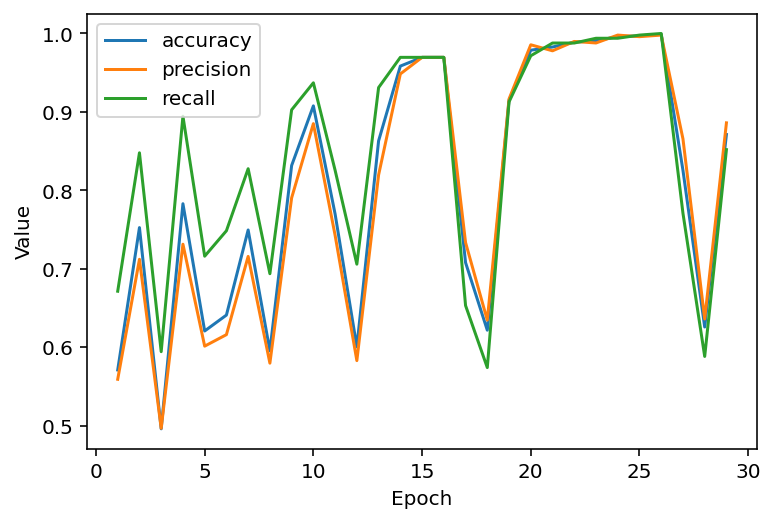

In [ ]:
learning_rate = 0.1
epochs = 30
batch_size = 300
label = train_y
classification_threshold = 0.45

# Establish the metrics the model will measure.
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 )
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_X, epochs, 
                           label, batch_size)

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
val_X = pd.DataFrame(val_X)
val_X.columns = [str(c) for c in val_X.columns]

features = {name:np.array(value) for name, value in val_X.items()}
label = val_y

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
1/1 [==============================] - 85s 85s/step - loss: 5.3275 - accuracy: 0.8000 - precision: 0.3333 - recall: 0.0357


[5.327487468719482, 0.800000011920929, 0.3333333432674408, 0.0357142873108387]

In [ ]:
labels = list(val_y)
raw_predictions = list(my_model.predict(features))

Consider rewriting this model with the Functional API.


In [ ]:
predictions = [p[0] for p in raw_predictions]
tf.math.confusion_matrix(labels, predictions)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[117,   0],
       [ 28,   0]], dtype=int32)>

## Ok não é tão bom assim quando não se tem sorte

In [ ]:
import pandas as pd
import numpy as np
import math

etudes_data = pd.read_csv('https://raw.githubusercontent.com/laiscarraro/Lalasinha-Academy/main/etudes_data.csv', index_col=0)

def split_midis(txt):
  return np.array([int(i) for i in txt.split(' ')])[:1565]

etudes_data['X'] = etudes_data['midi_list'].apply(split_midis)

def interval_count(l):
  rsp = []
  for i in range(1,len(l)):
    if l[i-1] == -1 or l[i] == -1: rsp.append(0)
    else: rsp.append(abs(l[i-1] - l[i]))
  return np.array(rsp)

etudes_data['X'] = etudes_data['X'].apply(interval_count)

def is_chopin(txt):
  if 'Chopin' in txt: return 1
  return 0

etudes_data['y'] = etudes_data['composer'].apply(is_chopin)

etudes_data = etudes_data.drop(columns=['composer', 'midi_list'])
etudes_data.head()

In [ ]:
X = pd.DataFrame([i for i in etudes_data['X']]).dropna(axis=0)
y = etudes_data.loc[X.index]['y']

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

from imblearn.over_sampling import RandomOverSampler
r = RandomOverSampler()
train_X, train_y = r.fit_resample(train_X, train_y)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

feature_columns = []
cols = [tf.feature_column.numeric_column(str(i)) for i in range(train_X.shape[1])]

for c in cols:
  feature_columns.append(c)

feature_layer = layers.DenseFeatures(feature_columns)

train_X = pd.DataFrame(train_X)
train_X.columns = [str(c) for c in train_X.columns]

feature_layer(dict(train_X))

In [ ]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  model = tf.keras.models.Sequential()
  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label,
                batch_size=None, shuffle=True):
  
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(label)
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist  

In [ ]:
import matplotlib.pyplot as plt

def plot_curve(epochs, hist, list_of_metrics):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

In [ ]:
learning_rate = 0.1
epochs = 100
batch_size = 300
label = train_y
classification_threshold = 0.4

# Establish the metrics the model will measure.
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 )
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_X, epochs, 
                           label, batch_size)

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
val_X = pd.DataFrame(val_X)
val_X.columns = [str(c) for c in val_X.columns]

features = {name:np.array(value) for name, value in val_X.items()}
label = val_y

my_model.evaluate(x = features, y = label, batch_size=batch_size)

In [ ]:
labels = list(val_y)
raw_predictions = list(my_model.predict(features))

In [ ]:
predictions = [p[0] for p in raw_predictions]
tf.math.confusion_matrix(labels, predictions)

In [ ]:
fp = [i for i in range(len(predictions)) if predictions[i] == 1 and labels[i] == 0]
fn = [i for i in range(len(predictions)) if predictions[i] == 0 and labels[i] == 1]
vp = [i for i in range(len(predictions)) if predictions[i] == 1 and labels[i] == 1]

In [ ]:
v2 = val_X.copy()
v2['i'] = v2.index
v2.index = list(range(len(v2)))

inds_fp = [v2.loc[i]['i'] for i in fp]
inds_fn = [v2.loc[i]['i'] for i in fn]
inds_vp = [v2.loc[i]['i'] for i in vp]

In [ ]:
e = pd.read_csv('https://raw.githubusercontent.com/laiscarraro/Lalasinha-Academy/main/etudes_data.csv', index_col=0)
fp_l = [e.loc[i]['composer'] + ' ' + str(e.loc[i]['midi_list']) for i in inds_fp]
fn_l = [e.loc[i]['composer'] + ' ' + str(e.loc[i]['midi_list']) for i in inds_fn]
vp_l = [e.loc[i]['composer'] + ' ' + str(e.loc[i]['midi_list']) for i in inds_vp]

print('Confundiu com:', [i.split('-1')[0] for i in fp_l])

In [ ]:
beth = [int(i) for i in fp_l[0][21:].split(' ')]

In [ ]:
ch_fn = [[int(i) for i in k[16:].split(' ')] for k in fn_l]
ch_vp = [[int(i) for i in k[16:].split(' ')] for k in vp_l]

In [ ]:
#@title Funções e bibliotecas

!apt-get install fluidsynth &> /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2 &> /dev/null
!apt-get install lilypond > /dev/null
!sudo apt-get install musescore &>/dev/null

from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from music21 import *

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(filename + '.wav'))

def show(music):
  return Image(filename=str(music.write('lily.png')))

us = environment.UserSettings()
us['lilypondPath'] = '/usr/bin/lilypond'
us['musescoreDirectPNGPath'] = '/usr/bin/musescore'
us['musicxmlPath'] = '/usr/bin/musescore'

def create_scale(scale_pitch, mode):
  s = stream.Stream()
  if mode == 'major':
    ps = scale.MajorScale(scale_pitch).pitches
  else:
    ps = scale.MinorScale(scale_pitch).pitches
  for p in range(len(ps)*2):
    if p == 8: continue
    n = note.Note()
    n.pitch = pitch.Pitch(ps[p%len(ps)].name)
    n.quarterLength = 1.0
    if p < 8:
      n.octave = 4
    else:
      n.octave = 5
    if n.pitch.name == scale_pitch and p > 0: n.octave += 1
    s.append(n)
  return s

import random

def get_chord(scale_pitch, mode):
  notes = [n for n in create_scale(scale_pitch, mode).notes]
  notes = notes[:len(notes)//2]
  f = random.randint(0, len(notes)-1)
  c = chord.Chord([notes[f], notes[(f+2)%len(notes)], notes[(f+4)%len(notes)]])
  return c

def random_scale_chord():
  ps = ['A', 'B', 'C', 'E', 'F', 'G']
  sh = [p+'#' for p in ps]
  b = [p+'b' for p in ps]
  ps = ps + b + sh

  rand_p = ps[random.randint(0,len(ps)-1)]
  m = random.randint(0,1)
  if m == 0:
    mode = 'major'
    ps = scale.MajorScale(rand_p).pitches
  else:
    mode = 'minor'
    ps = scale.MinorScale(rand_p).pitches
  
  s = stream.Stream()
  for p in ps:
    n = note.Note()
    n.pitch = p
    n.quarterLength = 1.0
    s.append(n)

  c = stream.Stream()
  c.append(key.Key(rand_p, mode))
  c.append(get_chord(rand_p, mode))

  return s, c

def random_chord():
  ps = ['A', 'B', 'C', 'E', 'F', 'G']
  sh = [p+'#' for p in ps]
  b = [p+'b' for p in ps]
  ps = ps + b + sh

  m = random.randint(0,1)
  if m == 1:
    mode = 'major'
  else:
    mode = 'minor'

  rand_p = ps[random.randint(0,len(ps)-1)]
  c = get_chord(rand_p, mode)
  
  return c

record_ex1 = 0
record_ex2 = 0
record_ex3 = 0

In [ ]:
s = stream.Stream()
# PROBLEMA: RECALL

# ch_fn[0] e 2: # Aeolian Harp, provavelmente porque é muito "poluída"
# ch_fn[4] e 13 # storm? algo assim, tb muito poluída
# ch_fn[5] # Winter Wind, muitas notas inúteis e algumas só que são importantes
# ch_fn[7] # Ocean, igual
# ch_fn[8] # Nocturne alguma coisa, calma demais comparada às outras
# ch_fn[9] # Black Keys, mesma coisa que as poluídas
# ch_fn[11] # não lembro o nome dessa mas também é do op 25
# ch_fn[12] # é a mais caótica do op 12

# RECONHECEU:
# ch_vp[2]: Storm ou algo assim. Hmmmmmmmmmmmmmm....
# ch_vp[4]: Winter Wind. HMMMMMMMMMMMMMMMMMMMMMMMMMMM........

for i in beth[:500]:
  ql = 0.25/1.7
  if i == -1: 
    n = note.Rest()
    n.quarterLength = ql
  else:
    n = note.Note()
    n.pitch.midi = i
    n.quarterLength = ql
  s.append(n)
play(s)

# Refatoração
- Na construção da matriz de inputs, deixar midis nulos como -1 (podemos considerar tudo como pausas) OK
- Criar uma função para criar o modelo e dar outputs, porque aí eu vou poder fazer otimização do meu próprio modelo com grid search e talvez algoritmos genéticos (usar do maior para o menor) OK
- Fazer holdout com biblioteca mesmo antes, e aí depois fazer cross validation e usar o erro do treinamento pra ajustar os hiperparâmetros OK
- Fazer crossval estratificado ao invés de usar oversampling
- Explicar melhor cada passo

# Ideias para as próximas tentativas
- Na extração de features, pegar todas as músicas (futuramente)
- Bag of words com intervalos? Com certeza não kkkk mas vamos ver, né (Update: deu certo.)
- Ao invés de pegar apenas o midi, pegar também o beatStrength e selecionar apenas as pausas e os midis que passam num threshold mínimo de beatStrength